# Lab  #2 - Gradient Descent For Logistic Regression

First and Last Name: Janakan Sivaloganathan

Student ID: 500960836

Objective: Predict the coronary heart diesease which has two classes of 0 or 1 using Logistic Regression based on all features (1 to 9).

In [143]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Dataset
A sample of males in a heart-disease high-risk region of the Western Cape, South Africa is leveraged.

In [144]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/tofighi/MachineLearning/master/datasets/heart.csv"
)
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   row.names  462 non-null    int64  
 1   sbp        462 non-null    int64  
 2   tobacco    462 non-null    float64
 3   ldl        462 non-null    float64
 4   adiposity  462 non-null    float64
 5   famhist    462 non-null    object 
 6   typea      462 non-null    int64  
 7   obesity    462 non-null    float64
 8   alcohol    462 non-null    float64
 9   age        462 non-null    int64  
 10  chd        462 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 39.8+ KB
None
        row.names         sbp     tobacco         ldl   adiposity       typea  \
count  462.000000  462.000000  462.000000  462.000000  462.000000  462.000000   
mean   231.935065  138.326840    3.635649    4.740325   25.406732   53.103896   
std    133.938585   20.496317    4.593024    2.070909    7.78069

In [145]:
data.head()

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


## Classification

## Implementation Details

### Exploratory Data Analysis

([<matplotlib.patches.Wedge at 0x11836c2b0>,
 [Text(-0.5106859893503832, 0.974268864472852, '0'),
  Text(0.5106860805680151, -0.9742688166589747, '1')],
 [Text(-0.2785559941911181, 0.5314193806215556, '65.37%\n302'),
  Text(0.27855604394619005, -0.5314193545412589, '34.63%\n160')])

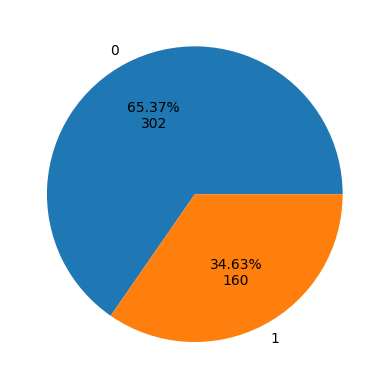

In [146]:
# How much is the percentage of each class 0 and 1?
total = data["chd"].value_counts().values.sum()


def fmt(x):
    return "{:.2f}%\n{:.0f}".format(x, total * x / 100)


plt.pie(
    data["chd"].value_counts().values,
    labels=data["chd"].value_counts().index,
    autopct=fmt,
)

Our diagram show cases that 65.4% of the class does not have coronary heart disease and 34.6% of the class does have coronary heart disease.

In [147]:
# How many missing values do we have?
data.isnull().sum()

row.names    0
sbp          0
tobacco      0
ldl          0
adiposity    0
famhist      0
typea        0
obesity      0
alcohol      0
age          0
chd          0
dtype: int64

From an analysis of missing values, there seems to be no missing values for our feature set.

In [148]:
# How many categorical variables you have in your features?
for column in data.columns:
    print(f"{column} : {len(data[column].value_counts().values)} value count")

# Limit to categorical data
data.select_dtypes(include=[object])

row.names : 462 value count
sbp : 62 value count
tobacco : 214 value count
ldl : 329 value count
adiposity : 408 value count
famhist : 2 value count
typea : 54 value count
obesity : 400 value count
alcohol : 249 value count
age : 49 value count
chd : 2 value count


,famhist
0,Present
1,Absent
2,Present
3,Present
4,Present
...,...
457,Absent
458,Absent
459,Absent
460,Absent


From a quick analysis by reviewing the raw Pandas dataframe values and the distinct value counts for each feature, it seems evident that there is only one categorical variable in our dataset, famhist as there are only a limit of 2 values (Present or Absent) excluding chd which is the output result if a person had coronary heart disease or not (1 or 0).

<Axes: >

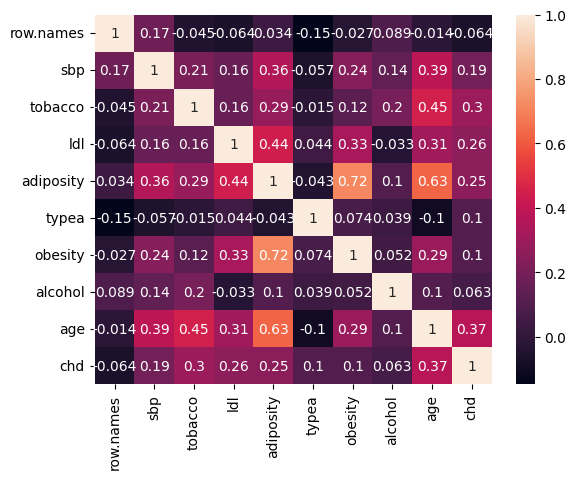

In [149]:
# What features have the maximum corrolation?
correlation_matrix = data.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True)

Correlations calculates the relationship between each column (or feature) in the dataset. The range is from -1 to 1, where -1 is a negative correlation (linearly decrease), 0 is no correlation, and 1 is high correlation (linearly increase).

The brightest colours depict which features have higher correlations compared to the rest. From a quick analysis of the correlation matrix, it seems that the features with the maximum corrolation of 0.72 (72%) is obesity vs adiposity.

### One-Hot-Encoding

In [150]:
# Encoding the family history variable (now 9 features instead of 8 features)
print(data["famhist"].nunique())
data_encoded = pd.get_dummies(
    data, columns=["famhist"], drop_first=True
)  # Only one encoded column is sufficient
data_encoded.head()

2


,row.names,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd,famhist_Present
0,1,160,12.00,5.73,23.11,49,25.30,97.20,52,1,True
1,2,144,0.01,4.41,28.61,55,28.87,2.06,63,1,False
2,3,118,0.08,3.48,32.28,52,29.14,3.81,46,0,True
3,4,170,7.50,6.41,38.03,51,31.99,24.26,58,1,True
4,5,134,13.60,3.50,27.78,60,25.99,57.34,49,1,True


### Standardization

In [151]:
# Normalize the other feature columns that are not categorical (code used from laboratory 1)
def standardize(feature_vector):
    """Standardization (Normalization)"""
    mean_avg = feature_vector.mean()
    std_avg = feature_vector.std()
    return (feature_vector - mean_avg) / std_avg


for column in data_encoded.columns:
    if column != "famhist_Present" and column != "row.names" and column != "chd":
        data_encoded[column] = standardize(data_encoded[column])

data_encoded.head()

,row.names,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd,famhist_Present
0,1,1.057417,1.821099,0.477894,-0.295183,-0.418017,-0.176594,3.274189,0.628654,1,True
1,2,0.276789,-0.789382,-0.159507,0.411694,0.193134,0.670646,-0.612081,1.381617,1,False
2,3,-0.991731,-0.774141,-0.608585,0.883374,-0.112441,0.734723,-0.540597,0.217947,0,True
3,4,1.545310,0.841352,0.806252,1.622382,-0.214300,1.411091,0.294742,1.039361,1,True
4,5,-0.211103,2.169453,-0.598928,0.305020,0.702427,-0.012842,1.645991,0.423301,1,True


### Hypothesis (Model)

In [152]:
# Define the sigmoid function
def sigmoid(z):
    z = z.astype(float)
    return 1 / (1 + np.exp(-z))

### Cost Function

In [153]:
# Define a function for calculating binary cross entropy loss function for a set of training examples with binary labels
def binary_cross_entropy_loss(y, h_theta):
    return -np.mean(y * np.log(h_theta) + (1 - y) * np.log(1 - h_theta))

### Batch Gradient Descent Iteration

In [154]:
# Define the function for updating the thetas iteratively from theta0 to theta9 with the additional bias
def batch_gradient_descent(X, y, theta, alpha, epochs):
    m = len(y)
    costs = []
    theta = theta.astype(float)
    alpha = float(alpha)
    for epoch in range(epochs):
        z = np.dot(X, theta)
        h_theta = sigmoid(z)
        gradient = (
            np.dot(X.T, (y.reshape(-1, 1) - h_theta)) / m
        )  # Reshape the target vector
        theta = theta + (alpha * gradient)
        cost = binary_cross_entropy_loss(y, h_theta)
        costs.append(cost)

    return theta, costs

In [155]:
# Define the function for updating the thetas with mini batches of 50
def mini_batch_gradient_descent(X, y, theta, alpha, epochs, batch_size):
    m = len(y)
    costs = []
    theta = theta.astype(float)
    alpha = float(alpha)

    num_batches = m // batch_size
    remainder_samples = m % batch_size

    for epoch in range(epochs):
        for i in range(num_batches):  # Process each batch then update
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            X_batch = X[start_idx:end_idx]
            y_batch = y[start_idx:end_idx]  # sample batches

            z = np.dot(X_batch, theta)
            h_theta = sigmoid(z)
            gradient = (
                np.dot(X_batch.T, (y_batch.reshape(-1, 1) - h_theta)) / batch_size
            )
            theta = theta + (alpha * gradient)

        # Remaining samples in the last batch
        if remainder_samples > 0:
            X_last_batch = X[end_idx:]
            y_last_batch = y[end_idx:]

            z_last_batch = np.dot(X_last_batch, theta)
            h_theta_last_batch = sigmoid(z_last_batch)
            gradient_last_batch = (
                np.dot(
                    X_last_batch.T, (y_last_batch.reshape(-1, 1)) - h_theta_last_batch
                )
                / remainder_samples
            )
            theta = theta + (alpha * gradient_last_batch)

        # Calculate cost for the entire dataset at the end of each epoch
        z_full = np.dot(X, theta)
        h_theta_full = sigmoid(z_full)
        cost = binary_cross_entropy_loss(y, h_theta_full)
        costs.append(cost)
    return theta, costs

### Initialization

In [156]:
# Initialization
# np.random.seed(5)
X = data_encoded.drop(["chd", "row.names"], axis=1)  # Remove 'row.names' from features
X.insert(0, "bias", 1)  # Add bias column
y = data_encoded["chd"].values  # Fix here - remove the .reshape(-1, 1)
theta_init = np.random.rand(X.shape[1], 1)
print(theta_init)

[[0.52677431]
 [0.74847319]
 [0.29338628]
 [0.56496086]
 [0.41560947]
 [0.18871625]
 [0.7800046 ]
 [0.9550676 ]
 [0.81933389]
 [0.86305102]]


### Learning Curves

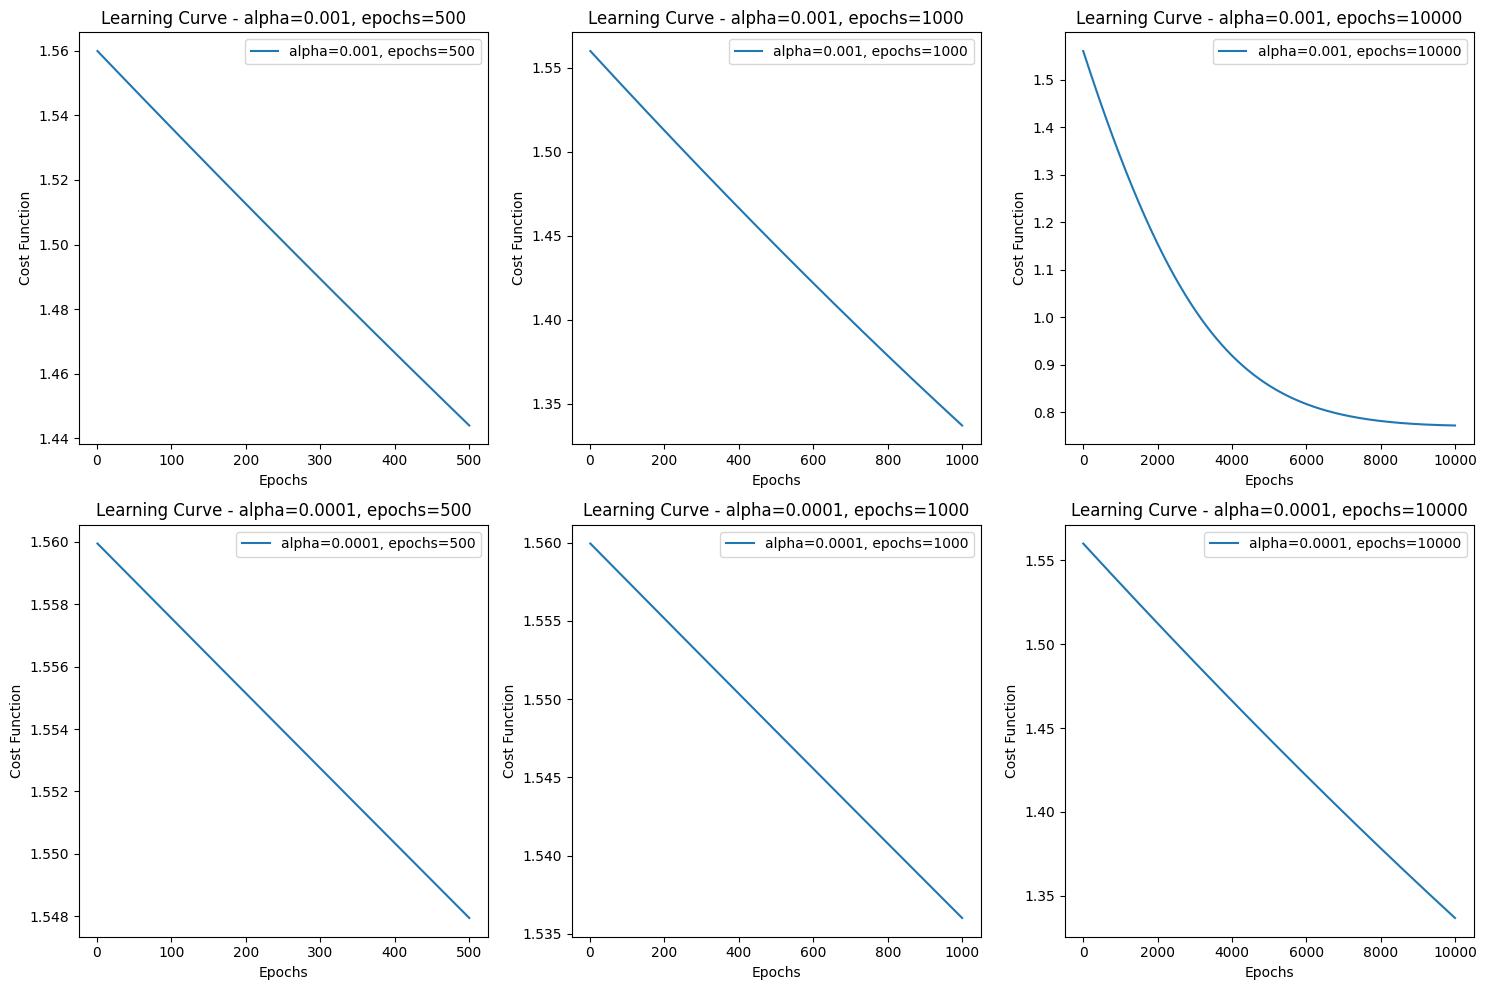

In [157]:
# Plot the cost function for different learning rates
batch_sizes = 50
learning_rates = [0.001, 0.0001]
epochs_list = [500, 1000, 10000]

fig, axes = plt.subplots(len(learning_rates), len(epochs_list), figsize=(15, 10))

for i, alpha in enumerate(learning_rates):
    for j, epochs in enumerate(epochs_list):
        theta_final, cost_history = batch_gradient_descent(
            X, y, theta_init, alpha, epochs
        )
        axes[i, j].plot(
            range(1, epochs + 1), cost_history, label=f"alpha={alpha}, epochs={epochs}"
        )
        axes[i, j].set_xlabel("Epochs")
        axes[i, j].set_ylabel("Cost Function")
        axes[i, j].set_title(f"Learning Curve - alpha={alpha}, epochs={epochs}")
        axes[i, j].legend()

plt.tight_layout()
plt.show()

### Learning curves

Based on the learning curves presented, the 10,000 epoch seems to be the best value for both the 0.001 and 0.0001 learning rates. This is because those respective graphs as presented above showcases a smooth decrease and a convergence where the cost nearly stabalizes (clearly presented by the curve). Since the learning rate of 0.001 is larger, there are less steps required (more profound curve) than the learning rate of 0.0001. Since epoch is a hyper-parameter for the gradient descent that controls the number of complete passes through the training dataset, an optimal choice of 10,000 for the provided learning rates would tune the model coefficients so that it presents a decent result.

### Mini-batch Gradient Descent Iteration

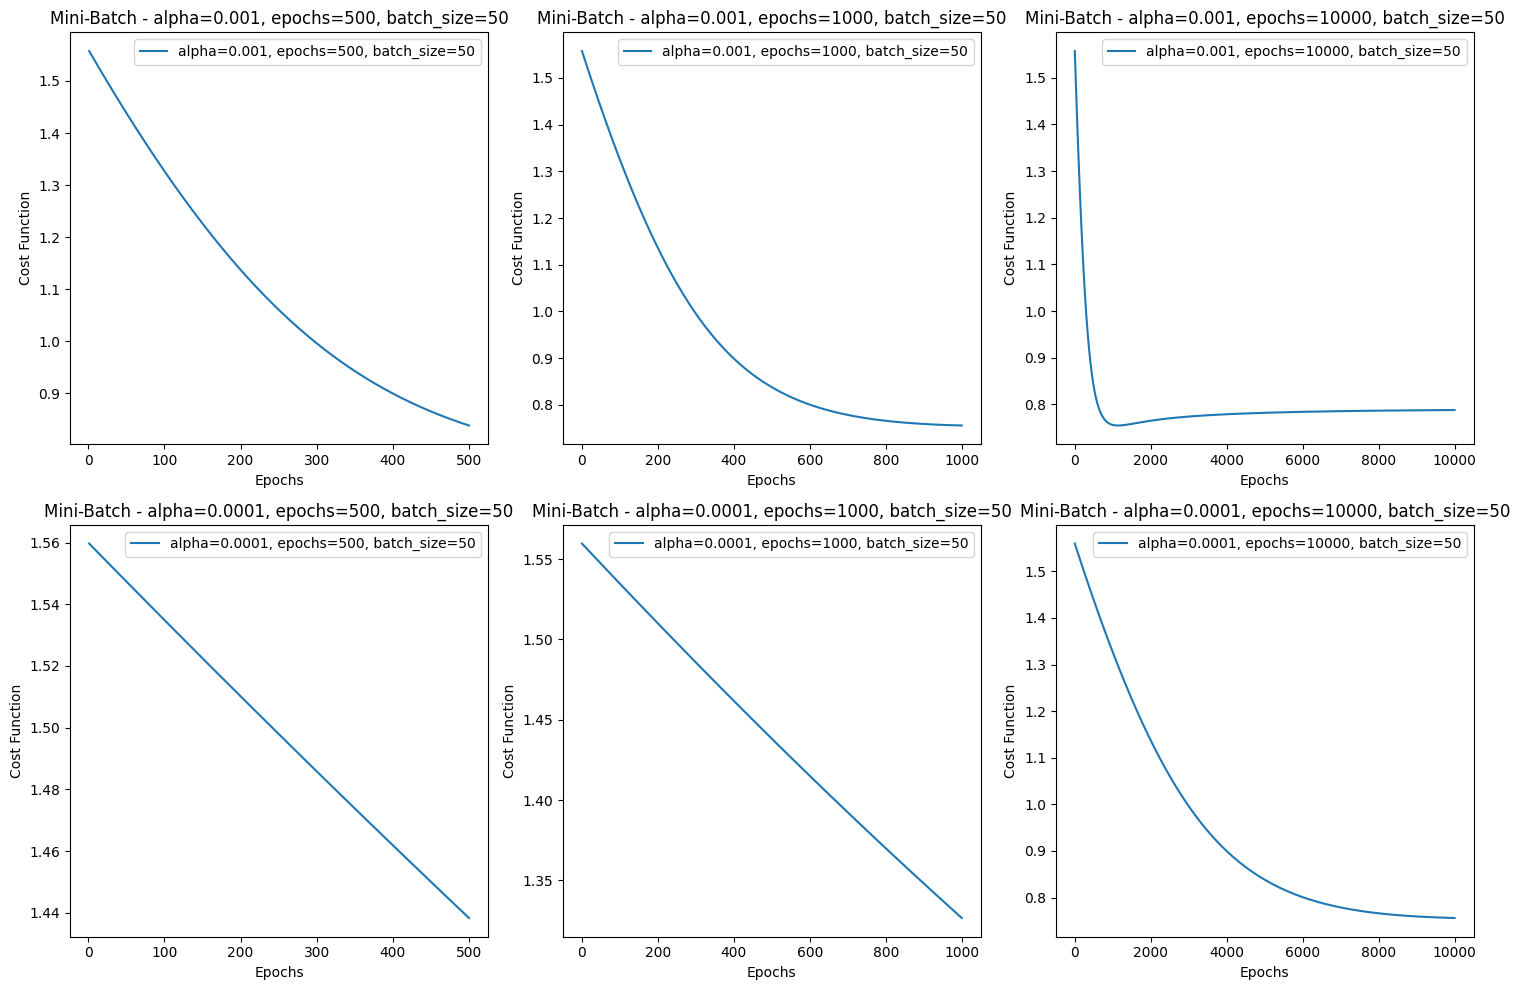

In [158]:
# Set the batch size to 50 samples and plotting the learning curves
fig, axes = plt.subplots(len(learning_rates), len(epochs_list), figsize=(15, 10))

for i, alpha in enumerate(learning_rates):
    for j, epochs in enumerate(epochs_list):
        theta_final_mini_batch, cost_history_mini_batch = mini_batch_gradient_descent(
            X, y, theta_init, alpha, epochs, batch_sizes
        )
        axes[i, j].plot(
            range(1, epochs + 1),
            cost_history_mini_batch,
            label=f"alpha={alpha}, epochs={epochs}, batch_size={batch_sizes}",
        )
        axes[i, j].set_xlabel("Epochs")
        axes[i, j].set_ylabel("Cost Function")
        axes[i, j].set_title(
            f"Mini-Batch - alpha={alpha}, epochs={epochs}, batch_size={batch_sizes}"
        )
        axes[i, j].legend()

plt.tight_layout()
plt.show()

### Mini-batch Gradient Descent Iteration

Based on the provided learning curves, an epoch of 500 for the learning rate of 0.001 and an epoch of 10,000 for the learning rate of 0.0001 for a batch size of 50 is required. Firstly, for the learning rate of 0.001, the gradient converges to a negative trangential allowing a smooth and optimal cost function as presented in the first figure of the graph. The second graph for 1,000 epochs showcases a trend of over fitting as it escapes the local minima and tries to over optimize, therefore this is ineffective and it is also presented in the the sequential graph after. Although the 10,000 epochs for 0.001 learning rate does seem to converge, this cost function is larger than the initial 500 epochs. For the learning rate of 0.0001, since we are adding the additional batch size (hyper-parameter of gradient descent that controls the number of training samples to work thorugh before the model's internal parameters are updated - [source](https://askdatascience.com/497/what-the-difference-between-batch-and-epoch-neural-network?show=497#q497)) of 50, 462/50 does not evenly train the model as there is a remaing of 12 samples left over before the next update. This maybe an improvement consideration. Nevertheless, the learning rate of 0.0001 is a very small incrememntal step for each iteration, and since the first 500 and 1000 epoch stages have not shown any significant improvement, the final graph would not be as drastic as well due to the samll updates. However, the epoch size of 10,000 does seem to be the most optimal for the learing rate of 0.0001 as there seems to be a more converging transition unlike the first two graphs. Although the first two graphs are in the smaller cost function boundaries, they are not demonstrating any form of convergence trend and therefore 10,000+ iterations of epoch would be the optimal choice for bach updates of 50 samples.

### Compare with Implemented LIbrary


In [159]:
# Comparing the results to the LogisticRegression implementation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [160]:
# Compare with implemented library
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Train the Logistic Regression model from scikit-learn
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Get coefficients from scikit-learn Logistic Regression
coefficients_sklearn = logreg.coef_.flatten()

# # Calculate probabilities using coefficients from implemented model
# z_impl = np.dot(X_test, theta_final)
# h_theta_impl = sigmoid(z_impl)

# # Apply a threshold to convert probabilities to class labels
# y_pred_impl = (h_theta_impl >= 0.5).astype(int)

# Calculate probabilities using coefficients from implemented model
z_impl_2 = np.dot(X_test, theta_final_mini_batch)
h_theta_impl_2 = sigmoid(z_impl_2)

# Apply a threshold to convert probabilities to class labels
y_pred_impl_2 = (h_theta_impl_2 >= 0.5).astype(int)

# Get classification predictions from scikit-learn Logistic Regression
y_pred_sklearn = logreg.predict(X_test)

# Print coefficients
# print("Coefficients from implemented batch gradient descent model:")
# print(theta_final)

print("Coefficients from implemented mini batch gradient descent model:")
print(theta_final_mini_batch)

print("\nCoefficients from sklearn LogisticRegression:")
print(logreg.coef_)

Coefficients from implemented mini batch gradient descent model:
[[-0.7359715517969269]
 [0.1258697103819306]
 [0.26418745357006873]
 [0.33976328776342646]
 [-0.05798417440170492]
 [0.2094342180694377]
 [-0.022693395459819514]
 [0.19445577929988522]
 [0.551347335005255]
 [0.44029136491985926]]

Coefficients from sklearn LogisticRegression:
[[-9.88888989e-06  1.96952733e-01  2.81557648e-01  4.21102305e-01
   1.97250500e-01  3.65952120e-01 -2.57043444e-01  2.77297743e-02
   5.95239993e-01  7.01671806e-01]]


In [161]:
from sklearn.metrics import classification_report

target_names = ["without coronary heart disease", "with coronary heart disease"]
# print(classification_report(y_test, y_pred_impl, target_names=target_names))
# print("---------")
print(classification_report(y_test, y_pred_impl_2, target_names=target_names))
print("---------")
print(classification_report(y_test, y_pred_sklearn, target_names=target_names))

                                precision    recall  f1-score   support

without coronary heart disease       0.81      0.81      0.81        90
   with coronary heart disease       0.65      0.65      0.65        49

                      accuracy                           0.76       139
                     macro avg       0.73      0.73      0.73       139
                  weighted avg       0.76      0.76      0.76       139

---------
                                precision    recall  f1-score   support

without coronary heart disease       0.78      0.84      0.81        90
   with coronary heart disease       0.66      0.55      0.60        49

                      accuracy                           0.74       139
                     macro avg       0.72      0.70      0.70       139
                  weighted avg       0.73      0.74      0.74       139



## Comparison with implemented library

When reviewing the latest coefficient results from my implemented model, it is evident that the values provided by the implmented model and the LogisticRegression model are different, but the classification results deem a similary overall accuracy of 73% validating that our library is correct. From a high level analysis there also does seem to showcase a slight similarity in terms of values as some of the smallest values in the LogisticRegression are presented as negatives in the respective implmenented theta values.It is to note that these score all based upon the random variables, compute resources, and the epochs leveraged. Overall, this comparison showcases that although the values are not identical, a similar pattern in the coefficients indicates that both models are learning similar relationships between features and target variable. It is also to note that there may be some false positives or negatives during the training process which may influence this score.

Text(0.5, 427.9555555555555, 'Predicted label')

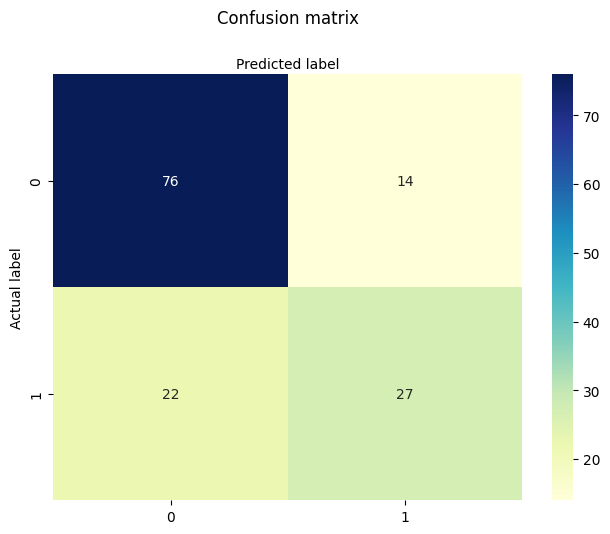

In [162]:
# Sample confusion matrix from the LogisticRegression library
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred_sklearn)
cnf_matrix

class_names = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt="g")
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

This confusion matrix showcases the predicted values in diagonal from the LogisticRegression model.

# Resources used:
https://www.datacamp.com/tutorial/understanding-logistic-regression-python

https://dataindependent.com/pandas/pandas-get-dummies-pd-get_dummies/
